This notebook contains code for:

1. KNN model classifying syllables as either Gurung or Nepali with some parameter tweaking
2. Voting Ensemble model using KNN, Decision Tree, and Logistic Regression models
3. Stacking Ensemble model using KNN, Decision Tree, and Logistic Regression models (meta model is Logistic Regression)

All models include cross-validation with 5 folds and a confusion matrix with a plot.

## Import Tools

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

## Import Pickled Dataframe of Nepali and Gurung Syllables
Data includes 5 speakers of each language saying ~92 words 3x each.

In [86]:
df = pd.read_pickle('all_gur_and_nep_data.csv')
df.head()

,language,speaker,time,word,phoneme,duration,F1,F2,F3,nasal,syllable_number,onset_c_place,onset_c_manner,laryngeal,coda
0,Nepali,1,8.422885,one,e,0.340285,570.820088,2773.608460,3421.056785,0,1,none,none,0,1
1,Nepali,1,9.794364,one,e,0.363759,555.260091,2818.847185,3332.194967,0,1,none,none,0,1
2,Nepali,1,10.912042,one,e,0.179386,522.733404,2736.485673,3301.971337,0,1,none,none,0,1
3,Nepali,1,20.259035,two,i,0.365618,449.909150,2762.010722,3349.317399,0,1,labial,sonorant,0,1
4,Nepali,1,21.365301,two,i,0.360141,388.329390,2799.204021,3345.667876,0,1,labial,sonorant,0,1


In [87]:
df.shape

(5099, 15)

In [88]:
df.language.value_counts()

Nepali    2786
Gurung    2313
Name: language, dtype: int64

## 1. KNN Model
Default parameters are the most accurate -- 5 neighbors and Euclidean distance. The good accuracy of this model is expected -- in linguistics, theories of categorical speech perception are actually quite similar to KNN models. Basically, each sound in a language is theorized to be represented as a cluster, the boundaries of which have been determined by exposure to many instances of that sound produced by many different speakers in many different environments. Following this model, when new input is recieved, it gets grouped with the cluster it is 'cloesest' to or shares the most features with, and thus is percieved as an instance of the sound that cluster represents.

In [89]:
##KNeighbors
## Adapted from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
## Code creates a pipline to scale the numeric data and one-hot-encode the categorical data.
numeric_features = ["duration", "F1", "F2", "F3"]
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

categorical_features = ["nasal", "syllable_number", "onset_c_place", "onset_c_manner", "laryngeal", "coda"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers =[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

## 5 neighbors, Euclidian distance
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())])

## Manhattan distance, performed less well
#clf = Pipeline(
   # steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(p=1))])

## Try fewer neighbors, performed less well
#clf = Pipeline(
  #  steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors=3))])

## Try more neighbors, performed less well
#clf = Pipeline(
   # steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors=7))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("cross validation scores:", scores)
print("model score: %.3f" % clf.score(X_test, y_test))

cross validation scores: [0.89583333 0.91176471 0.89460784 0.8872549  0.8797546 ]
model score: 0.917


In [90]:
## Confusion Matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[396,  51],
       [ 34, 539]])

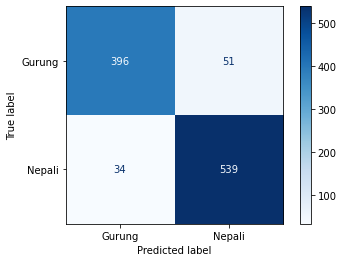

In [91]:
## Plot confusion matrix, code adapted from example here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 2. Voting Ensemble Model

In [92]:
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
lr = LogisticRegression(C=1000)

In [93]:
model_list = [('knn', knn), ('tree', dt), ('log_reg', lr)]

In [94]:
## Voting
## Adapted from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
## Code creates a pipline to scale the numeric data and one-hot-encode the categorical data.
numeric_features = ["duration", "F1", "F2", "F3"]
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

categorical_features = ["nasal", "syllable_number", "onset_c_place", "onset_c_manner", "laryngeal", "coda"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers =[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", VotingClassifier(estimators=model_list, voting='hard', weights=None))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("cross validation scores:", scores)
print("model score: %.3f" % clf.score(X_test, y_test))

cross validation scores: [0.88357843 0.91053922 0.88970588 0.89093137 0.87730061]
model score: 0.899


In [95]:
## Confusion Matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[385,  62],
       [ 41, 532]])

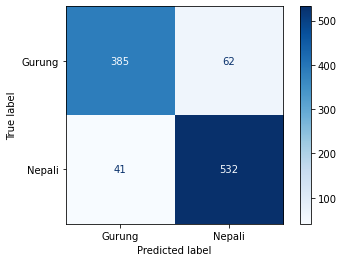

In [96]:
## Plot confusion matrix, code adapted from example here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 3. Stacking Ensemble Model
Meta model is a Logistic Regression model. This model has the best accuracy of all models.

In [97]:
## Stacking (cross-validation built-in)
## Adapted from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
## Code creates a pipline to scale the numeric data and one-hot-encode the categorical data.
numeric_features = ["duration", "F1", "F2", "F3"]
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

categorical_features = ["nasal", "syllable_number", "onset_c_place", "onset_c_manner", "laryngeal", "coda"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers =[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", StackingClassifier(estimators=model_list, final_estimator=LogisticRegression()))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.910


In [98]:
## Confusion Matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[397,  50],
       [ 42, 531]])

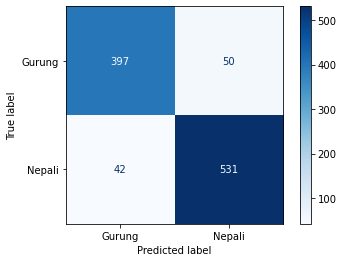

In [100]:
## Plot confusion matrix, code adapted from example here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('stacking_confusion_matrix.png')
plt.show()